### Rebecq, H., Gallego, G., Mueggler, E., and Scaramuzza, D. (2017). EMVS: Event-Based Multi-View Stereo—3D Reconstruction with an Event Camera in Real-Time. International Journal of Computer Vision 1–21.

This notebook is an implementation of the above paper on semi-dense 3D reconstruction of a scene using back projection methods. The scene data is captured using an event camera. 

In [2]:
import cv2
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
import pyquaternion as qt
%matplotlib notebook
data_path = 'data/slider_depth'

## Table of Contents
[1. Scene Video(optional)](#scene_video)

[2. Data Available and Data format](#data)
    
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Camera Matrix](#cam_mat)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Obtaining pose information relevant to events under consideration from the groundtruth files](#event_data)
 
[3. Stages of Reconstruction](#stages)

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Back-Projection](#stage_1)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Ray-Counting](#stage_2)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3 Voting](#stage_3)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4 Scene Restructuring](#stage_4)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5 Cleaning](#stage_5)
   
    
[4. Algorithm](#algorithm)

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Pictorial Representation of the Algorithm](#algo_pic)

[5. The Main Function](#main)

In [3]:
num_of_depth_planes = 100 # number of depth planes to be used for the 3-D projective Space
Z_0 = 10  # The reference plane for initial mapping, 10 has been chosen arbitrarily

<a id="scene_video"></a>
## 1. Scene Video


The DAVIS camera has a conventional image capturing system along with the event based system. While we shall not be using the conventional stream during our implementation, the conventional stream of data helps the user visualize the scene that is undergoing reconstruction.

In [4]:
normal_img_path = data_path + '/images'
normal_imgs = [normal_img_path + "/" + img for img in os.listdir(normal_img_path) if img.endswith(".png")]
normal_imgs.sort()

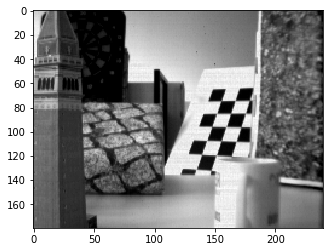

In [4]:
#### optional code snippet, Run this part if you wish to visualise the data as a video. The below sequence makes use
#### of conventional images frames and is not used anywhere else later in the notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.canvas.draw()
ax.axis()
for image in normal_imgs:
    ax.clear()
    ax.imshow(plt.imread(image), cmap='gray')
    fig.canvas.draw()

<a id="data"></a>
## 2. Data Available and Data format


There are various kinds of data which we would have to work with namely, event data, imu data, calibration parameters, and ground truth data. There is also an 'images.txt' file which gives the timestamps at which synchronous event stream was captured. The format of the data are as shown below. 

![description of dataset format](Images/data_format_emvs.png)

<a id="cam_mat"></a>
### 2.1 Camera Matrix

Every camera has a calibration matrix which is dependant on the intrinsic and extrinsic parameters being used. We obtain these parameters from the <i>calib.txt</i> file.

In [5]:
def return_camera_matrix(filename='calib.txt'):
    '''
    Returns the camera matrix for the given dataset based on calibration parameters.
    
    Parameters:
    -----------
    filename : <string>
        name of the text file where the camera parameters are stored
    
    Return:
    -------
    camera_mat: <np.array>
        The camera matrix for the parameters mentioned in the calibration file
    '''
    
    file = open(data_path +'/' + filename, "r")
    cam_par = list(map(float,file.readline().split()))
    file.close()
    fx, fy, cx, cy, k1, k2, p1, p2, k3 = [par for par in cam_par]
    camera_mat = np.array([[fx,  0, cx],
                           [ 0, fy, cy],
                           [ 0,  0,  1]])
    return camera_mat, [k1, k2, p1, p2, k3]

In [6]:
def return_undistorted_coordinates(dist_cam_cords, distortion_params):
    '''
    Utility under consideration
    '''
    k1, k2, p1, p2, k3 = distortion_params
    
    pass

In [7]:
cam_mat, dist_params = return_camera_matrix()

<a id="event_data"></a>
### 2.2 Obtaining pose information relevant to events under consideration from the groundtruth files


The objective is to get an event and its corresponding pose for that particular time stamp. Since the number of events are huge and the homographies are expensive to compute, a batch of 256 events is assigned the same pose information. 

In [8]:
from itertools import islice
def bundle_events(batch_number, filename='events.txt', batch_size = 256):
    ''' 
    Return a batch of events from the file containing event information. Sometimes the event file can run into several 
    Gigabytes of storage. This is why a file is opened and closed everytime a batch of events needs to be read.
    
    Parameters:
    -----------
    batch_number : <int>
        The nth batch which needs to be read
    filename : <string>
    
    Return:
    -------
    events : <list>
        events of the form [start_time, ex, ey, polarity]
    event_start_time: <float>
        The starting time of the current batch of events
    '''
    events=[]
    file = open(data_path +'/' + filename, "r")
    head = list(islice(file, batch_number * batch_size, (batch_number + 1)*batch_size))
    #return timestamp of first event in the batch
    event_start_time = list(map(float,head[0].split()))[0] 
    for line in head:
        events.append(list(map(float,line.split())))
    file.close()
    return events, event_start_time

In [9]:
events, event_start_time = bundle_events(batch_number=40)
print(event_start_time)

0.048514001


The pose is sampled at frequencies lower than the event data. In order to capture pose information for an event at some timestamp, it is thus necessary to linearly interpolate the pose data for that timestamp. As the trajectory is continuous and the sampling time is very small, we can assume the path between two timesteps to be fairly linear.

In [10]:
def get_ground_truth_pose(event_start_time, filename='groundtruth.txt'):
    
    ''' 
    This function returns the the groundtruth pose for an event depending on the timestamp 
    of the input given as input to the function. If pose of the event is linearly interpolated 
    if the timestamp of the event given falls in between the timestamps of the poses of the two 
    events
    
    Parameters:
    -----------
    event_start_time : <float>
        timestamp of event for which pose information is to be estimated
    filename : <string>
        name of the file containing the groundtruth
        
    Return:
    -------
    pose : <list> of format [timestamp, px, py, pz, qx, qy, qz, qw]
        Returns a list describing the pose at the timestamp given by the event
    
    '''
    file = open(data_path +'/' + filename, "r")
    prev_pose = [0, 0, 0, 0, 0, 0, 0, 1]
    prev_time = prev_pose[0]  #start with initial time 0s 
    
    for line in file:
        current_pose = list(map(float,line.split()))
        current_time = current_pose[0]
        
        if event_start_time == current_time:
            return np.array(current_pose) #pose information for that time-step
        
        elif event_start_time > prev_time and event_start_time < current_time:
            return linearly_interpolated_pose(current_pose, prev_pose, event_start_time) 
            
        elif event_start_time > current_time:
            prev_pose = current_pose
            prev_time = prev_pose[0]

In [11]:
def linearly_interpolated_pose(pose_t, pose_t_minus_1, time_bet):
    
    ''' 
    Function to linearly interpolate the quaternion and translation values for the timesteps provided
    
    Parameters:
    -----------
    pose_t : <list>
        list containing pose information of the time step greater than required time 
    pose_t_minus_1 : <list>
        list containing pose information of the time step lesser than required time
    time_bet: <float>
        Time for which pose information is required
    
    Return:
    -------
    estimated_pose : <list>
        Returns a list containing the linearly interpolated pose estimate
    '''
    
    # We will doing slerp on quaternions and linear intepolation on the translation vectors
    estimated_pose = []
    interpolater = time_bet/(pose_t[0] - pose_t_minus_1[0])
    
    interpolated_translation = interpolater *(np.array(pose_t[1:4]) - np.array(pose_t_minus_1[1:4]))
    
    
    pose_t_minus_1_qt = qt.Quaternion(pose_t_minus_1[7], pose_t_minus_1[4], pose_t_minus_1[5], pose_t_minus_1[6])
    
    pose_t_qt = qt.Quaternion(pose_t[7], pose_t[4], pose_t[5], pose_t[6]) 
    # the order of pose in the dataset and that used in the pyquaternion library is different, hence the restructuring
    
    interpolated_rotation = qt.Quaternion.slerp(pose_t_minus_1_qt, pose_t_qt, interpolater)
    eqw ,eqx, eqy, eqz = interpolated_rotation.elements
    px, py, pz = interpolated_translation
    
    return [time_bet, px, py, pz, eqx, eqy, eqz, eqw]

The below code is run to see how the pose information is calculated for different event times where the events are sampled in batches.

In [55]:
def get_info():
    for batch in range(10):
        events, event_start_time = bundle_events(batch)
        info = get_ground_truth_pose(event_start_time)
        #print('For batch number {}, the event starts at {} second with translation vector, t={} and rotational quaternion={}'
              #.format(batch, info[0], info[1:4], info[4:]))

In [56]:
get_info()

In [57]:
%timeit get_info()

12.3 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
def get_translation_rotation(pose):
    
    '''
    Get the translation vector and rotation matrix from the pose which contains a quaternion
    
    Parameters:
    -----------
    pose : <list>
        A list contating the translation vectors and quaternion for rotation
    
    Return:
    -------
    t : <np.array, 1x3>
        An array of translation co-ordinates
    R : <np.array, 3x3>
        A matrix containing the rotational information
    '''
    
    pose_qt = qt.Quaternion(pose[7], pose[4], pose[5], pose[6])
    R = pose_qt.rotation_matrix
    t = np.array(pose[1:4]).reshape((3,1))
    return t,R

In [16]:
t, R = get_translation_rotation([0.003811, 0.019094251027136612, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
print("Translation:\n{} \n Rotation:\n{}".format(t, R))

Translation:
[[0.01909425]
 [0.        ]
 [0.        ]] 
 Rotation:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [150]:
%timeit get_translation_rotation([0.003811, 0.019094251027136612, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

45.2 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
t = np.array([0.019094251027136612, 0, 0]).reshape(3, 1)
R = np.eye(3,3)

<a id="stages"></a>
## 3. Stages of Reconstruction


The algorithm for Event based Multi View Stereo proposed here uses five stages to do the reconstruction. It makes use of the Collins space sweep approach with a few changes. Projective sampling is used instead of uniform sampling. Also the thresholding is Adaptive Gaussian as opposed to Global thresholding used in Collins' algorithm.

<a id="stage_1"></a>
### 3.1 Backprojection


The 2-D points in the event stream are backprojected into a 3-D space. Since the event camera detects only edges, we can assume the rays corresponding to the same feature would intersect/ go very close to each in some unit volume.

<img src="Images/backprojection.png" alt="backprojection" style="width: 400px;"/>


In [18]:
def map_to_reference_view(events, t, R):
    '''
    Function to find out the initial homography matrix to map event co-ordinates to the Z_0 plane of 
    the reference view
    
    Parameters:
    -----------
    events : <np.array, batch_sizex4>
        A  containing event information namely [timestamp, ex, ey, polarity] of one batch of size batch_size
    t : <np.array, 3x1>
        The translation part of the pose
    R : <np.array, 3x3>
        The Rotational part of the pose
        
    Return:
    -------
    mapped_coordinates : <np.array, batch_sizex2>
        all the x and y co-ordinates mapped to the reference Z_0
    
    '''
    co_ords = np.vstack((events[:, 1], events[:, 2], np.ones((events.shape[0], )))) 
    
    e = np.reshape(np.array([0, 0, 1]), (1, 3)) 
    H_Z0  = np.linalg.inv(R + (t @ e)/Z_0)
    mapped_coordinates = (H_Z0 @ co_ords).T      
    #print (mapped_coordinates)
    #if np.max(mapped_coordinates[:,0]) > 239 or np.max(mapped_coordinates[:,1]) > 179 :
       # print(" out of bounds {} and {}".format(np.max(mapped_coordinates[:,0], np.max(mapped_coordinates[:,1])))
    return mapped_coordinates[:,0:2] #is this correct or should it be normalised by the third column?

In [19]:
n = np.array(events)

In [20]:
ref_plane_mapped_events = map_to_reference_view(n, t, R)


In [83]:
%timeit map_to_reference_view(n, t, R)

92.4 µs ± 928 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
def homography(ref_plane_mapped_events, Z_i, t, R):
    '''
    Compute the homography for the input positions and  pose. The homography has been calculated as per
    the methods outlined in the paper in section 7.1. Z_0 is defined as a global variable later in the code
    
    Parameters:
    -----------
    ref_plane_mapped_events : <np.array, batch_sizex2>
        Event coordinates mapped to the reference plane
        
    Z_i : <int> 
        Current depth plane
    t : <np.array, 1x3>
        An array of translation co-ordinates
    R : <np.array, 3x3>
        A matrix containing the rotational information
    Return:
    -------
    depth_plane_mapped_events : <np.array, batch_sizex2>
        Event coordinates mapped to the current depth plane
    '''
    
    Cx, Cy, Cz = -(R.T @ t).T[0]  # camera centers , fix this monstrosity
    
    delta = (Z_i - Z_0)/(Z_0 - Cz)
    
    m1 = np.vstack((ref_plane_mapped_events[:, 0], np.ones((ref_plane_mapped_events.shape[0]), dtype='float64')*Cx)).T
    m2 = np.vstack((ref_plane_mapped_events[:, 1], np.ones((ref_plane_mapped_events.shape[0]), dtype='float64')*Cy)).T
    
    m_final = np.vstack((m1,m2))
    
    m3 = np.array([[Z_0*delta/Z_i],
                  [(1-delta)/Z_i]])
    
    cur_depth_mapped_events = m_final @ m3
    
    x_ref_mapped = cur_depth_mapped_events[:ref_plane_mapped_events.shape[0]]
    y_ref_mapped = cur_depth_mapped_events[ref_plane_mapped_events.shape[0]:]
    
    depth_plane_mapped_events = np.hstack((x_ref_mapped, y_ref_mapped))
    #if np.max(depth_plane_mapped_events[:,0]) > 239 or np.max(depth_plane_mapped_events[:,1]) > 179 :
        #print(" out of bounds {} and {}".format(np.max(depth_plane_mapped_events[:,0], np.max(depth_plane_mapped_events[:,1]))))
    return depth_plane_mapped_events

In [22]:
depth_plane_mapped_events = homography(ref_plane_mapped_events, 20, t, R) # value of Z_i should be greater than Z_0,
#  random value of 20 chosen for testing

In [92]:
%timeit homography(ref_plane_mapped_events, 20, t, R)

122 µs ± 1.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id="stage_2"></a>
### 3.2 Volumetric Ray Counting


We assume our backprojected rays from different views to pass through some 3-D Volume divided into voxels. A scoring function is associated with each voxel. The score of each voxel is determined by the number of rays passing through it. It is given as shown below. <b>X</b> is the co-ordinate of the centre of a voxel.

<img src="Images/scoring.png" alt="scoring" style="width: 200px;"/>

In [23]:
def ray_counting(voxel_space, vol_coords, z_index=0):
    '''This function assigns votes to the voxel space based on the number of times vol_coords appear. Vol_coords are
    indices computed from depth plane mapped events'''
    shp = voxel_space.shape 
    idx = vol_coords[:,0]*shp[2] + vol_coords[:,1] + z_index*shp[2]*shp[1]
    np.add.at(voxel_space.ravel(),idx,1)
    return voxel_space

In [24]:
def vote(voxel_space, Z_i, depth_plane_mapped_events, vote_type='nearest_neighbour'):
    ''' 
    The function recieves floating values as co-ordinates. This function assigns a vote to the appropriate voxel by 
    approximating it the nearest integer co-ordinates using some correction scheme.
    
    Parameters:
    -----------
    voxel_space : <np.array, number_of_depth_planes x camera_width x camera_height>
        The volume to which depth mapped events vote 
        
    Z_i : <int>
        The current depth plane for voting process
        
    depth_plane_mapped_events : <np.array, batch_sizex2>
        Event coordinates mapped to the current depth plane
    
    vote_type : <string>
        bilinear or nearest neighbour
        
    Return:
    -------
     <np.array, number_of_depth_planes x camera_width x camera_height>
       volume with voted events 
    '''
    if vote_type=='nearest_neighbour':
        depth_vol_coords = np.round(depth_plane_mapped_events).astype(int)
        prev_votes = np.array(voxel_space, copy=True)  
        voxel_space = np.zeros(voxel_space.shape)
        return prev_votes + ray_counting(voxel_space, depth_vol_coords, z_index=Z_i-(Z_0+1))

In [25]:
voxel_space = np.zeros((100, 240, 180))

In [26]:
voxel_space = vote(voxel_space ,20, depth_plane_mapped_events) # random value of 20 used for Z_i for testing

In [254]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [257]:
%lprun -f  vote vote(voxel_space,20-(Z_0+1), depth_plane_mapped_events)

<a id="stage_3"></a>
### 3.3 Thresholding


Local maxima of <b>f(X)</b> is determined here. It is done by by using adaptive gaussian thresholding on the confidence map c(x,y). After this procedure a scene structure should have been formed.

In [27]:
from skimage.filters import threshold_local
def adaptive_gaussian_thresholding(volume_slice, kernal_size, C):
    '''
    This function does adaptive gaussian thresholding of the 3-D voxel space
    
    Parameters
    ----------
    volume_slice : <np.array, 1 x camera_width x camera_height>
        The (1 x camera_width x camera_height) array which define the center of the voxel co-ordinates after having accumulated votes in the 
        voting process
    
    kernal_size : <int>
        The size of the adaptive window to be used. 5 specified in the paper
    
    C : The offset value to be used for the adaptive filter. -10 is specified in the paper
    
    Returns
    ------- 
    final_values : <np.array, 1 x camera_width x camera_height>
        A (1 x camera_width x camera_height) array on which adaptive gaussian thresholding has been successfully performed
    '''
    
    binary_adaptive = threshold_local(volume_slice, kernal_size, C)
    final_values = np.multiply(volume_slice, binary_adaptive)
    return final_values

In [28]:
thresholded_slice = adaptive_gaussian_thresholding(voxel_space[20 - (Z_0+1), :, :], 5, -10)

In [213]:

%timeit adaptive_gaussian_thresholding_2(voxel_space[20 - (Z_0+1), :, :], 5, -10)

156 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id="stage_4"></a>
### 3.4 Scene Merging


This is used to merge scenes obtained while the camera is moving. The key reference view is changed when the distance moved by the camera w.r.t to the reference view exceeds some percentage of the mean scene depth (15 to 40%)

In [31]:
def calc_mean_depth(volume):
    '''
        Calculate the mean depth of the volume. Only voxels which contain a value are considered for the mean depth.

        Parameters:
        -----------
        volume: <np.array, number_of_depth_planes x camera_width x camera_height>
             Input 3-D volume which may contain value greater than 0 in its voxels
        Return: 
        -------
        mean_depth :<float>
            mean depth calculated
    '''
    depth_weight = 0
    tot = 0
    for z in range(volume.shape[0]):
        vol_slice = volume[z, :, :]
        weight = vol_slice[vol_slice>0].size
        tot += weight
        depth_weight += weight * z
    if tot==0:
        return 0
    else:
        mean_depth = depth_weight/tot
        return mean_depth

In [278]:
%lprun -f  calc_mean_depth calc_mean_depth(voxel_space)

In [33]:
def check_reference_switch(volume, t, t_prev, mean_depth_factor = 0.2):
    '''
    Returns True if mean depth is 15% to 40% of the mean_depth of the scene. 
    Parameters :
    ------------
    volume : <np.array, number_of_depth_planes x camera_width x camera_height>
    t : <np.array, 1x3>
        An array of translation co-ordinates
    t : <np.array, 1x3>
        An array of prev translation co-ordinates
    mean_depth_factor : <float>
        default value of 20%(0.2) assigned. Guidelines of 15 to 40 % in paper
    
    Return: 
    --------
    <bool>
        True if a reference view change is required
    
    '''
    mean_depth = calc_mean_depth(volume)
    dist_travelled = np.linalg.norm(t-t_prev)
    
    if dist_travelled > mean_depth_factor * mean_depth:
        return True
    else:
        return False

In [34]:
tplus1 = np.array([1, 0, 0]).reshape(3,1)
check_reference_switch(voxel_space ,tplus1, t)

False

In [35]:
%lprun -f  check_reference_switch check_reference_switch(voxel_space ,tplus1, t)

UsageError: Line magic function `%lprun` not found.


In [36]:
%timeit check_reference_switch(voxel_space ,tplus1, t)

6.93 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
def get_transformed_vol_from_prev_voxel_space(prev_vol_vectors, curr_volume, R, t):
    '''
    This generates a new 3-D space based on the 3-D space obtained after current transformation and the 
    3-D space obtained earlier(prev volume vectors). The volume vectors define the point in space where the 3-D 
    space has some value greater than 0.
    
    Parameters
    ----------
    prev_vol_vectors : <list, nx3>
        The list of vectors in the previous volume where the points defined by them had values greater than 0
    
    curr_volume : <np.array, number_of_depth_planes x camera_width x camera_height>
        The 3-D space of the current reference view
    
    t : <np.array, 1x3>
        An array of translation co-ordinates
        
    R : <np.array, 3x3>
        A matrix containing the rotational information
    
    Returns
    ------- 
    thresholded_volume : <np.array, 1 x camera_width x camera_height>
        A (1 x camera_width x camera_height) array on which adaptive gaussian thresholding has been successfully performed
    '''
    
    transformed_vol_vectors = []
    orig_vol_vectors = np.argwhere(curr_volume)
    

    # array is of form nX(z,x,y), the below code makes the array of form nX(x, y, z)
    ###############################################
    my_permutation = [2, 0, 1]
    i = np.argsort(my_permutation)
    orig_vol_vectors = orig_vol_vectors[:, i]
    ################################################
    
    # Keep in mind that the shape of the vectors we get from the volume is (z,x,y) while the shape need for 
    # computing transformations is (x, y, z)
    transformed_vol_vectors = (R@(orig_vol_vectors).T + t).T
    
    #nearest neighbour voting 
    transformed_vol_vectors = (np.round(transformed_vol_vectors)).astype(int)
    
    # array is of form nX(x,y,z), the below code makes the array of form nX(z, x, y)
    ###############################################
    my_permutation = [1, 2, 0]
    i = np.argsort(my_permutation)
    transformed_vol_vectors = transformed_vol_vectors[:, i] 
    ################################################
    
    tot_vectors = transformed_vol_vectors.tolist() + prev_vol_vectors
    volume_vectors_set = set(tuple(vector) for vector in  tot_vectors)
    volume_vectors_list = [list(vector) for vector in volume_vectors_set]

    return volume_vectors_list

In [290]:
prev_vol_vectors = [[0, 0, 1], [0, 2 ,3], [2, 4, 56], [34, 23 ,45], [21, 34 ,67]]
%timeit get_transformed_vol_from_prev_voxel_space(prev_vol_vectors, voxel_space, R, t)

63.1 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<a id="stage_5"></a>
### 3.5 Cleaning and Plotting


The edges obtained are cleaned using median filters and radius filters

In [39]:
def clean(volume):
    volume = median_filter(volume)
    volume = radius_filter(volume)
    return volume

In [40]:
def radius_filter(volume):
    '''to be filled later '''
    return volume

In [41]:
def median_filter(volume):
    '''to be filled later'''
    return volume

In [42]:
def plot_3D_space_and_convert_to_point_cloud(volume_3D, destination):
    pass

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import pylab as pl
from IPython import display

def plot_3D_space(volume_vector_list):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = np.array(volume_vector_list)[:, 1]
    ys = np.array(volume_vector_list)[:, 2]
    zs = np.array(volume_vector_list)[:, 0]
    ax.scatter(xs, ys, zs)
    #display.clear_output(wait=True)
    #display.display(pl.gcf())
    #time.sleep(0.001)

<a id="algorithm"></a>
## 4. The Algorithm


The algorithm given by Rebecq et al. is as shown below. Note that there are some guidelines given by Rebecq et al. to speed up computations which must be followed.

<img src="Images/algorithm.png" alt="The Algorithm" style="width: 400px;" align='left'/>

<a id="algo_pic"></a>
### 4.1 Pictorial Representation of the Algorithm



<img src="Images/Visualization_of_ EVMS_process.png" alt="visualising EVMS homographies" style="width: 400px;" align='center'/>

<a id="main"></a>
# 5. The Main function


In [44]:
num_of_depth_planes = 100 # number of depth planes to be used for the 3-D projective Space
Z_0 = 10  # The reference plane for initial mapping, 10 has been chosen arbitrarily

In [48]:
def main(batches):
    '''
    batches = number of batches of events the function has to run for.
    '''
    voxel_space = np.zeros((num_of_depth_planes, 240, 180)) # the resolution of the camera is 240x180
    reference_vol_vectors = [] # the reference vol vectors which have to be plotted in 3-D space later
    
    t = np.array([0, 0, 0]).reshape((3,1)) # initial values of t and R
    R = np.eye(3)
    for batch in range(batches): 
        events, event_start_time = bundle_events(batch_number=batch)
        pose = get_ground_truth_pose(event_start_time)
        t_prev, R_prev = t , R
        t, R = get_translation_rotation(pose)
        
        if check_reference_switch(voxel_space, t, t_prev):
            #voxel_space = clean(voxel_space)
            reference_vol_vectors = get_transformed_vol_from_prev_voxel_space(reference_vol_vectors, 
                                                                              voxel_space, R_prev, t_prev) 
            voxel_space = np.zeros((num_of_depth_planes, 240, 180)) #  Re-initialize voxel space for new reference
               
        ref_plane_mapped_events = map_to_reference_view(np.array(events), t, R)
            
        for Z_i in range(Z_0+1, num_of_depth_planes+Z_0+1): # if Z_0 is 0 then divide by zero errors occur, therefore Z_0+1 used
            
            #parallelize this using multithreading in the end, 
            
            depth_plane_mapped_events = homography(ref_plane_mapped_events, Z_i, t, R) 
            voxel_space = vote(voxel_space, Z_i, depth_plane_mapped_events)
            voxel_space[Z_i - (Z_0+1), :, :] = adaptive_gaussian_thresholding(voxel_space[Z_i - (Z_0+1), :, :], 5, -10) 
    
    print(reference_vol_vectors)
    if reference_vol_vectors:
        plot_3D_space(reference_vol_vectors)

###########################################to be done later###############################################       
#scored_space = clean(voxel_space)
#plt.plot(scored_space)  # plot scored space continuously
        

In [54]:
main(5)

[]


In [52]:
print (event_start_time)

0.048514001


In [ ]:
%prun main(10)

# Scratchpad

### recheck calculations

## To-do:
##### 1. How would one use camera matrix in this paper, is it not necessary?
##### 2. Filter implementations to be done 
#### how to implement union of the transformed volume at each step?
## Bottlenecks in code
### Make file opening and closing more efficient
### Make Vote for function faster 
### Parallelize the code for the depth planes part

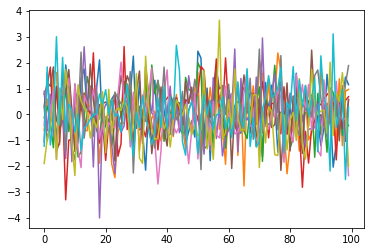

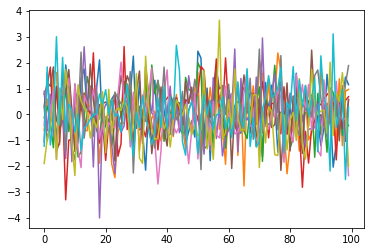

In [33]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)
